In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import string

np.random.seed(1312)  # 312

# ==================== 数据准备 ====================
# x = [116.46, 117.2, 121.48, 106.54, 91.11, 87.98, 106.27, 111.65, 108.33, 126.63]
# y = [39.92, 39.13, 31.22, 29.59, 29.97, 43.77, 38.47, 40.82, 22.84, 45.75]
# dist = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J'}

# 随机生成70个城市的坐标 (x: 经度, y: 纬度)
x = [np.random.uniform(-180, 180) for _ in range(20)]  # 经度范围 -180 到 180
y = [np.random.uniform(-90, 90) for _ in range(20)]   # 纬度范围 -90 到 90

# 生成城市名称映射，使用字母 A-Z 和 AA-ZZ 的组合
def generate_city_labels(n):
    labels = []
    for i in range(n):
        if i < 26:
            labels.append(string.ascii_uppercase[i])
        else:
            labels.append(string.ascii_uppercase[i // 26 - 1] + string.ascii_uppercase[i % 26])
    return labels

dist = {i: label for i, label in enumerate(generate_city_labels(20))}

# 计算距离矩阵
num_cities = len(x)
DIS = np.zeros((num_cities, num_cities))
for i in range(num_cities):
    for j in range(num_cities):
        DIS[i,j] = np.sqrt((x[i]-x[j])**2 + (y[i]-y[j])**2)

In [2]:
# ==================== 改进的贪心算法 ====================
def greedy_tsp(distances, num_solutions=20, k=5):
    """
    改进的贪心算法，从最近的k个城市中随机选择下一个城市
    :param distances: 距离矩阵
    :param num_solutions: 生成解的数量
    :param k: 从最近的k个城市中随机选择
    :return: 生成的解列表
    """
    n = len(distances)
    solutions = []
    for _ in range(num_solutions):
        start_city = np.random.randint(n)
        path = [start_city]
        unvisited = set(range(n)) - {start_city}
        while unvisited:
            last = path[-1]
            # 获取所有未访问城市及其距离
            candidates = [(city, distances[last, city]) for city in unvisited]
            # 按距离排序
            candidates.sort(key=lambda x: x[1])
            # 选择前k个最近的（如果存在k个）
            k_nearest = min(k, len(candidates))
            # 随机选择一个
            next_city = candidates[np.random.randint(0, k_nearest)][0]
            path.append(next_city)
            unvisited.remove(next_city)
        solutions.append(path)
    return solutions


In [3]:
# ==================== 蚁群算法实现 ====================
class ACO_TSP:
    def __init__(self, distances, num_ants=200, max_iter=50, alpha=1, beta=3, rho=0.1, Q=1):
        self.distances = distances
        self.num_ants = num_ants
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.Q = Q
        self.n = len(distances)
        self.pheromone = np.ones((self.n, self.n)) * 0.1
        self.best_path = None
        self.best_length = float('inf')
        self.frames = []
    
    def run(self):
        for _ in range(self.max_iter):
            all_paths = []
            for _ in range(self.num_ants):
                path = self.build_path()
                all_paths.append(path)
            self.update_pheromone(all_paths)
            self.record_frame(all_paths)
    
    def build_path(self):
        path = [0]
        unvisited = set(range(1, self.n))
        while unvisited:
            current = path[-1]
            probs = []
            for city in unvisited:
                phe = self.pheromone[current][city] ** self.alpha
                vis = (1/(self.distances[current][city]+1e-10)) ** self.beta
                probs.append(phe * vis)
            probs = np.array(probs) / sum(probs)
            next_city = np.random.choice(list(unvisited), p=probs)
            path.append(next_city)
            unvisited.remove(next_city)
        return path
    
    def update_pheromone(self, all_paths):
        self.pheromone *= (1 - self.rho)
        for path in all_paths:
            length = self.calc_path_length(path)
            delta = self.Q / length
            for i in range(len(path)-1):
                self.pheromone[path[i], path[i+1]] += delta
            self.pheromone[path[-1], path[0]] += delta
            if length < self.best_length:
                self.best_length = length
                self.best_path = path + [path[0]]
    
    def calc_path_length(self, path):
        return sum(self.distances[path[i], path[i+1]] for i in range(len(path)-1)) \
               + self.distances[path[-1], path[0]]
    
    def record_frame(self, all_paths):
        current_path = all_paths[0] + [all_paths[0][0]]
        x_curr = [x[i] for i in current_path]
        y_curr = [y[i] for i in current_path]
        x_best = [x[i] for i in self.best_path]
        y_best = [y[i] for i in self.best_path]
        self.frames.append(('ACO', x_curr, y_curr, x_best, y_best, self.best_length))

In [4]:
# ==================== 粒子群算法实现 ====================
class PSO_TSP:
    def __init__(self, distances, num_particles=500, max_iter=200, w=0.8, c1=1.5, c2=1.5):
        self.distances = distances
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w  # 惯性权重
        self.c1 = c1  # 个体学习因子
        self.c2 = c2  # 社会学习因子
        self.n = len(distances)
        self.gbest_path = None
        self.gbest_length = float('inf')
        self.frames = []
        
        # 初始化粒子（修正速度类型）
        self.particles = []
        for _ in range(num_particles):
            path = np.random.permutation(self.n).tolist()
            velocity = 0  # 改为标量值
            pbest_path = path.copy()
            pbest_length = self.calc_path_length(path)
            if pbest_length < self.gbest_length:
                self.gbest_length = pbest_length
                self.gbest_path = path.copy()
            self.particles.append({
                'path': path,
                'velocity': velocity,
                'pbest_path': pbest_path,
                'pbest_length': pbest_length
            })
    
    def run(self):
        for iter in range(self.max_iter):
            for p in self.particles:
                # 修正速度计算（使用标量运算）
                v_pbest = self.difference(p['path'], p['pbest_path'])
                v_gbest = self.difference(p['path'], self.gbest_path)
                
                new_velocity = (self.w * p['velocity'] +
                              self.c1 * np.random.rand() * v_pbest +
                              self.c2 * np.random.rand() * v_gbest)
                
                # 限制速度范围
                new_velocity = np.clip(new_velocity, 0, self.n//2)
                
                # 更新路径
                new_path = self.apply_velocity(p['path'], new_velocity)
                new_length = self.calc_path_length(new_path)
                
                # 更新最优解
                if new_length < p['pbest_length']:
                    p['pbest_path'] = new_path.copy()
                    p['pbest_length'] = new_length
                    if new_length < self.gbest_length:
                        self.gbest_length = new_length
                        self.gbest_path = new_path.copy()
                p['path'] = new_path
                p['velocity'] = new_velocity
            
            self.record_frame()
    
    def difference(self, current, target):
        """计算两个路径的差异（交换次数）"""
        swap_count = 0
        temp = current.copy()
        for i in range(self.n):
            if temp[i] != target[i]:
                j = temp.index(target[i])
                temp[i], temp[j] = temp[j], temp[i]
                swap_count += 1
        return swap_count
    
    def apply_velocity(self, path, velocity):
        """应用速度（执行交换操作）"""
        new_path = path.copy()
        swap_times = int(abs(velocity))
        for _ in range(swap_times):
            i, j = np.random.choice(self.n, 2, replace=False)
            new_path[i], new_path[j] = new_path[j], new_path[i]
        return new_path

        
    def calc_path_length(self, path):
        return sum(self.distances[path[i], path[i+1]] for i in range(self.n-1)) \
               + self.distances[path[-1], path[0]]
    
    def record_frame(self):
        current_path = self.particles[0]['path'] + [self.particles[0]['path'][0]]
        x_curr = [x[i] for i in current_path]
        y_curr = [y[i] for i in current_path]
        x_best = [x[i] for i in self.gbest_path] + [x[self.gbest_path[0]]]
        y_best = [y[i] for i in self.gbest_path] + [y[self.gbest_path[0]]]
        self.frames.append(('PSO', x_curr, y_curr, x_best, y_best, self.gbest_length))

In [5]:
# ==================== 遗传算法实现 ====================
class GA_TSP:
    def __init__(self, distances, pop_size=500, max_iter=200, pc=0.8, pm=0.05, greedy_ratio=0.05):
        self.distances = distances
        self.pop_size = pop_size
        self.max_iter = max_iter
        self.pc = pc  # 交叉概率
        self.pm = pm  # 变异概率
        self.n = len(distances)
        self.best_path = None
        self.best_length = float('inf')
        self.frames = []
        
        # 初始化种群
        # self.population = [np.random.permutation(self.n).tolist() for _ in range(pop_size)]
        # 初始化种群（部分使用贪心算法生成）
        self.population = []
        # 加入贪心解
        greedy_solutions = greedy_tsp(distances, num_solutions=int(pop_size*greedy_ratio))
        self.population.extend(greedy_solutions)
        # 加入随机解
        while len(self.population) < pop_size:
            self.population.append(np.random.permutation(self.n).tolist())
        
    
    def run(self):
        for it in range(self.max_iter):
            # 评估适应度
            fitness = [1/self.calc_path_length(p) for p in self.population]
            
            # 记录最佳路径
            current_best_idx = np.argmax(fitness)
            current_best_length = self.calc_path_length(self.population[current_best_idx])
            if current_best_length < self.best_length:
                self.best_length = current_best_length
                self.best_path = self.population[current_best_idx].copy()
            
            # 选择
            selected = self.selection(fitness)
            
            # 交叉
            offspring = []
            for i in range(0, len(selected), 2):
                if i+1 < len(selected):
                    child1, child2 = self.crossover(selected[i], selected[i+1])
                    offspring.extend([child1, child2])
            
            # 变异
            offspring = [self.mutation(ind) for ind in offspring]
            
            # 替换
            self.population = offspring[:self.pop_size]
            
            self.record_frame()
    
    def selection(self, fitness):
        # 轮盘赌选择
        total = sum(fitness)
        probs = [f/total for f in fitness]
        selected_idx = np.random.choice(len(self.population), size=len(self.population), p=probs)
        return [self.population[i] for i in selected_idx]
    
    def crossover(self, parent1, parent2):
        # 顺序交叉 (OX)
        if np.random.rand() < self.pc:
            size = len(parent1)
            cx1 = np.random.randint(0, size)
            cx2 = np.random.randint(cx1, size)
            
            child1 = parent1[cx1:cx2]
            for gene in parent2:
                if gene not in child1:
                    child1.append(gene)
                    
            child2 = parent2[cx1:cx2]
            for gene in parent1:
                if gene not in child2:
                    child2.append(gene)
            return child1, child2
        else:
            return parent1, parent2
    
    def mutation(self, individual):
        # 交换变异
        if np.random.rand() < self.pm:
            i, j = np.random.choice(self.n, 2, replace=False)
            individual[i], individual[j] = individual[j], individual[i]
        return individual
    
    def calc_path_length(self, path):
        return sum(DIS[path[i], path[i+1]] for i in range(self.n-1)) + DIS[path[-1], path[0]]
    
    def record_frame(self):
        current_path = self.population[0] + [self.population[0][0]]
        x_curr = [x[i] for i in current_path]
        y_curr = [y[i] for i in current_path]
        x_best = [x[i] for i in self.best_path] + [x[self.best_path[0]]] if self.best_path else []
        y_best = [y[i] for i in self.best_path] + [y[self.best_path[0]]] if self.best_path else []
        self.frames.append(('GA', x_curr, y_curr, x_best, y_best, self.best_length))

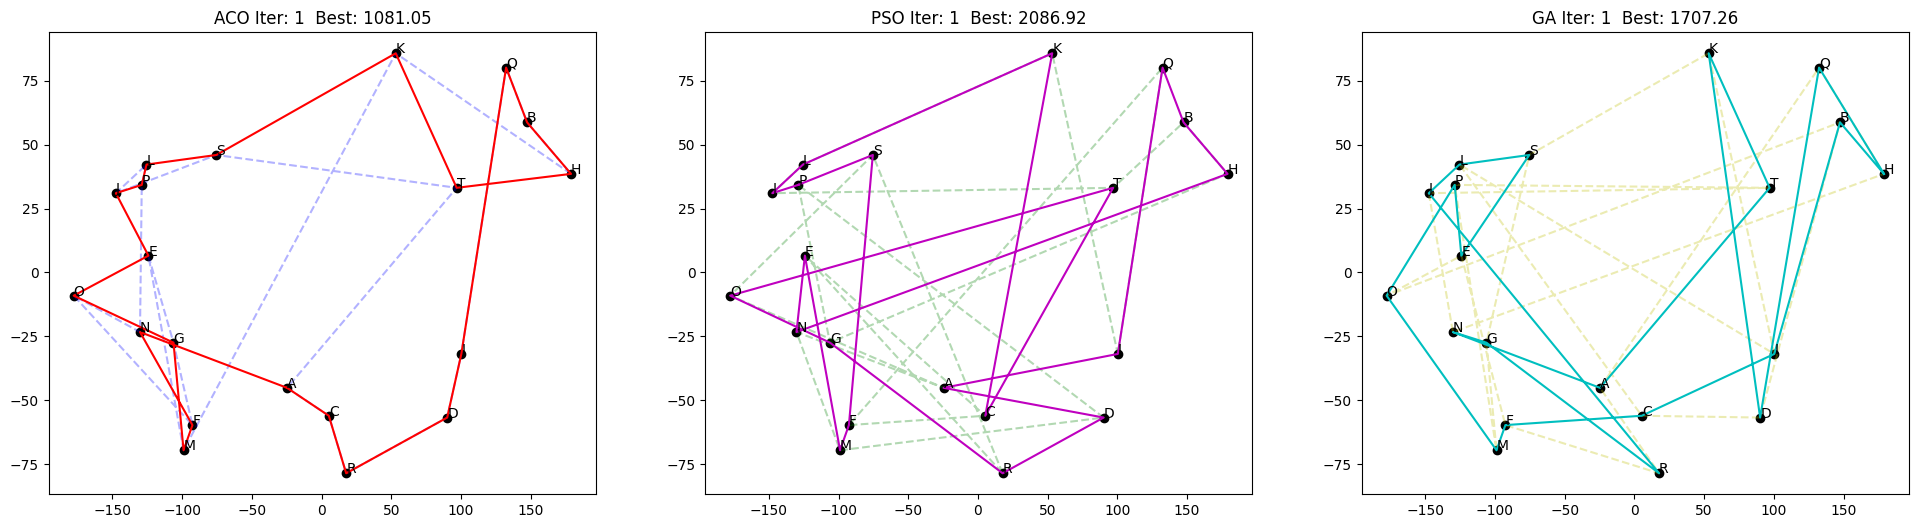

In [6]:
# ==================== 更新动画部分 ====================
# 创建画布（调整为3个子图）
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# 初始化所有算法
aco = ACO_TSP(DIS)
pso = PSO_TSP(DIS)
ga = GA_TSP(DIS)

# 运行所有算法
aco.run()
pso.run()
ga.run()

# 合并三个算法的帧数据
max_frames = max(len(aco.frames), len(pso.frames), len(ga.frames))
all_frames = []
for i in range(max_frames):
    aco_frame = aco.frames[i] if i < len(aco.frames) else aco.frames[-1]
    pso_frame = pso.frames[i] if i < len(pso.frames) else pso.frames[-1]
    ga_frame = ga.frames[i] if i < len(ga.frames) else ga.frames[-1]
    all_frames.append( (aco_frame, pso_frame, ga_frame) )

# 动画更新函数
def update(frame):
    aco_frame, pso_frame, ga_frame = all_frames[frame]
    
    # 更新蚁群算法视图
    ax1.clear()
    ax1.scatter(x, y, c='black')
    for i, txt in enumerate(dist.values()):
        ax1.annotate(txt, (x[i], y[i]))
    ax1.plot(aco_frame[1], aco_frame[2], 'b--', alpha=0.3)
    ax1.plot(aco_frame[3], aco_frame[4], 'r-')
    ax1.set_title(f"{aco_frame[0]} Iter: {frame+1}  Best: {aco_frame[5]:.2f}")
    
    # 更新粒子群算法视图
    ax2.clear()
    ax2.scatter(x, y, c='black')
    for i, txt in enumerate(dist.values()):
        ax2.annotate(txt, (x[i], y[i]))
    ax2.plot(pso_frame[1], pso_frame[2], 'g--', alpha=0.3)
    ax2.plot(pso_frame[3], pso_frame[4], 'm-')
    ax2.set_title(f"{pso_frame[0]} Iter: {frame+1}  Best: {pso_frame[5]:.2f}")
    
    # 更新遗传算法视图
    ax3.clear()
    ax3.scatter(x, y, c='black')
    for i, txt in enumerate(dist.values()):
        ax3.annotate(txt, (x[i], y[i]))
    ax3.plot(ga_frame[1], ga_frame[2], 'y--', alpha=0.3)
    ax3.plot(ga_frame[3], ga_frame[4], 'c-')
    ax3.set_title(f"{ga_frame[0]} Iter: {frame+1}  Best: {ga_frame[5]:.2f}")
    
    return ax1, ax2, ax3

# 创建动画
ani = FuncAnimation(fig, update, frames=len(all_frames), interval=300)

# 显示动画
HTML(ani.to_html5_video())

# ani.save('./assets/tsp.gif', writer='pillow', fps=5)